# Modeling

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from catboost import CatBoostRegressor
import shap


from sklearn.preprocessing import MinMaxScaler

## Prepare the Data Sets
We want to create two separate datasets; one for our CatBoost model and one for our Keras models.

In [14]:
df = pd.read_parquet("../data/raw/input_dataset-2.parquet")
df = df.dropna()

In [15]:
X_cols = ["Unit_4_Power", "Unit_4_Reactive Power", "Turbine_Guide Vane Opening", "Turbine_Pressure Drafttube", "Turbine_Pressure Spiral Casing", "Turbine_Rotational Speed"]
y_cols = [c for c in df if c.endswith("Tensile")]

### Create CatBoost dataset

In [16]:
lookback = 20

cX = df[X_cols].copy()
for i in range(1, lookback+1):
    cX.loc[:, [f"{c} (t-{i})" for c in X_cols]] = cX[X_cols].shift(i).rename(columns={c: f"{c} (t-{i})" for c in X_cols})

cX = cX[[c for c in cX if c not in X_cols]]
cy = df[y_cols]

cX

,Unit_4_Power (t-1),Unit_4_Reactive Power (t-1),Turbine_Guide Vane Opening (t-1),Turbine_Pressure Drafttube (t-1),Turbine_Pressure Spiral Casing (t-1),Turbine_Rotational Speed (t-1),Unit_4_Power (t-2),Unit_4_Reactive Power (t-2),Turbine_Guide Vane Opening (t-2),Turbine_Pressure Drafttube (t-2),...,Turbine_Guide Vane Opening (t-19),Turbine_Pressure Drafttube (t-19),Turbine_Pressure Spiral Casing (t-19),Turbine_Rotational Speed (t-19),Unit_4_Power (t-20),Unit_4_Reactive Power (t-20),Turbine_Guide Vane Opening (t-20),Turbine_Pressure Drafttube (t-20),Turbine_Pressure Spiral Casing (t-20),Turbine_Rotational Speed (t-20)
timepoints,,,,,,,,,,,,,,,,,,,,,
1970-12-29 10:59:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-12-29 10:59:58,311.093257,4.949223,94.206187,150.827828,5305.873472,108.033198,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-12-29 10:59:59,311.103996,5.051777,94.206457,150.774664,5305.690188,108.033197,311.093257,4.949223,94.206187,150.827828,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-12-29 11:00:00,311.114735,5.154330,94.206726,150.559452,5305.466701,108.033196,311.103996,5.051777,94.206457,150.774664,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-12-29 11:00:01,311.125475,5.256883,94.206995,150.344239,5305.243213,108.033195,311.114735,5.154330,94.206726,150.559452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971-01-25 11:06:44,308.685656,4.382225,94.422329,157.885326,5281.215929,108.057505,308.655287,4.809967,94.418992,157.924633,...,94.362264,158.728007,5282.350036,108.057619,308.108652,4.311835,94.358928,158.501036,5282.203114,108.057625
1971-01-25 11:06:45,308.716025,3.974309,94.425666,157.927905,5280.929965,108.057498,308.685656,4.382225,94.422329,157.885326,...,94.365601,158.954979,5282.496959,108.057612,308.139020,4.309002,94.362264,158.728007,5282.350036,108.057619
1971-01-25 11:06:46,308.746393,4.103262,94.429003,157.974925,5280.633358,108.057492,308.716025,3.974309,94.425666,157.927905,...,94.368938,159.181950,5282.643881,108.057606,308.169389,4.357300,94.365601,158.954979,5282.496959,108.057612


In [17]:
def train_test_split(X, y, test_percent=0.1, offset_percent=0):
    
    test_start = int(len(df) * offset_percent)
    test_end = int(len(df) * (offset_percent + test_percent))

    X_train, X_test = X.iloc[:test_start], X.iloc[test_start:test_end]
    y_train, y_test = y.iloc[:test_start], y.iloc[test_start:test_end]
    
    return X_train, X_test, y_train, y_test

cX_train, cX_test, cy_train, cy_test = train_test_split(cX, cy, test_percent=0.1, offset_percent=0.9)

### CatBoost Modeling

In [18]:
params = {
    "loss_function": "MAPE",
    "iterations": 100,
    "depth": 5
}

cy_trains = [cy_train[c] for c in cy_train]
cy_tests = [cy_test[c] for c in cy_test]

models = []

for j in range(len(cy_trains)):
    model = CatBoostRegressor(**params)
    model.fit(cX_train, cy_trains[j], eval_set=(cX_test, cy_tests[j]), verbose=False)
    models.append(model)

In [19]:
model = models[0]

In [20]:
explainer = shap.Explainer(model)
shap_values = explainer(cX_train)

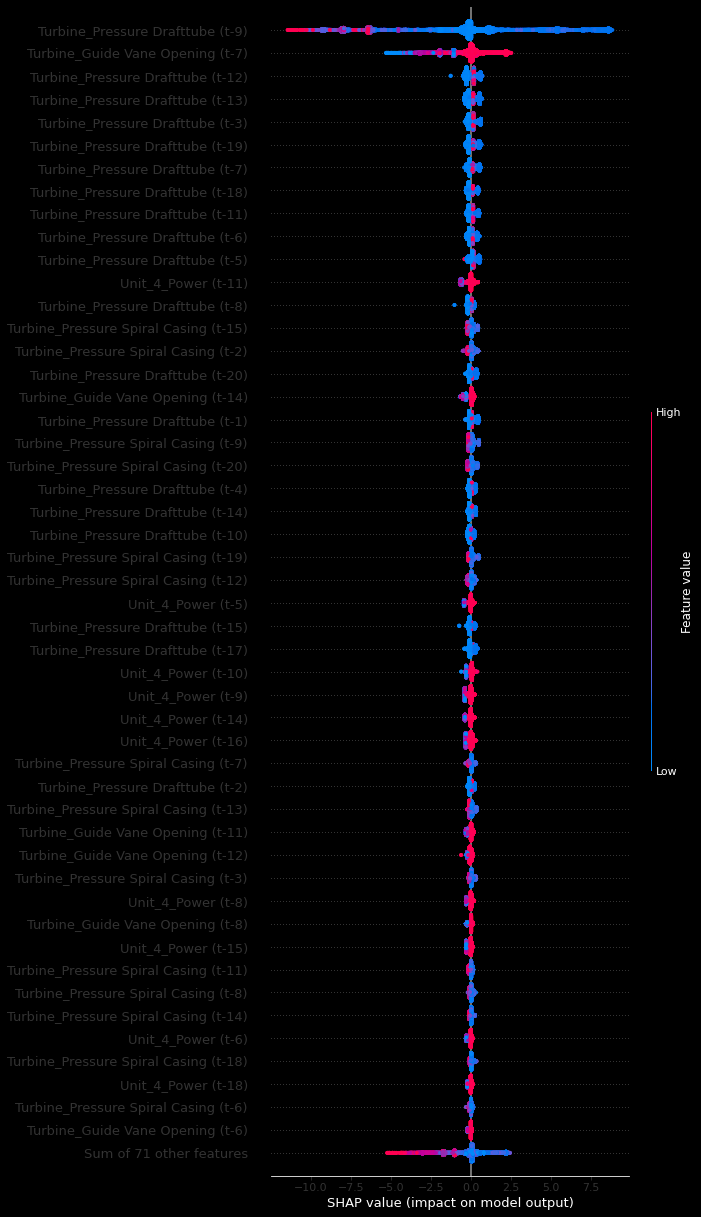

In [23]:
shap.plots.beeswarm(shap_values, max_display=50, order=shap_values.abs.mean(0))

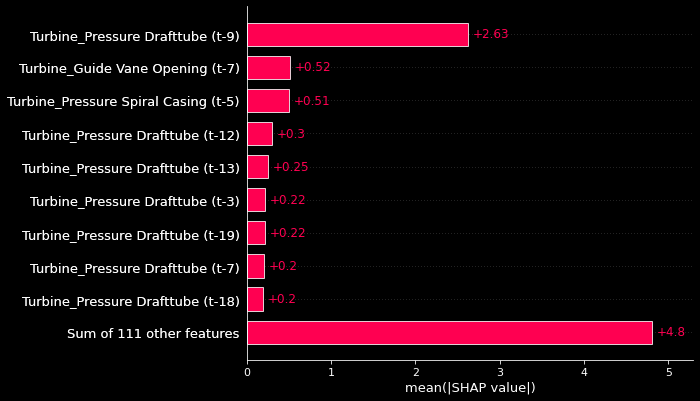

In [24]:
shap.plots.bar(shap_values.abs.mean(0))